In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd

print(tf.__version__)
print(len(tf.config.experimental.list_physical_devices('GPU')))

2.7.0
1


In [2]:
#IMPORTAÇÃO E NORRMALIZAÇÃO
(x_train, y_train), (x_test,y_test) = keras.datasets.cifar10.load_data()
#x_train = x_train.reshape(-1, 28, 28, 1)
#x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype(float)/255
x_test = x_test.astype(float)/255

#CRIAR DATASET
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(50000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_accuracy = tf.keras.metrics.Accuracy()
test_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_accuracy = tf.keras.metrics.Accuracy()

In [4]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(32, 32,3),batch_size=64),
     
        keras.layers.Conv2D(32, (3, 3), name="conv1", activation='relu',padding='same'),
        keras.layers.BatchNormalization(name="bn1"),  
        keras.layers.Conv2D(32, (3, 3),name="conv2", activation='relu', padding='same'),
        keras.layers.BatchNormalization(name="bn2"),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp1"),
        keras.layers.Dropout(0.2),
        keras.layers.Conv2D(64, (3, 3),name="conv3", activation='relu', padding='same'),
        keras.layers.BatchNormalization(name="bn3"),
        keras.layers.Conv2D(64, (3, 3),name="conv4", activation='relu', padding='same'),
        keras.layers.BatchNormalization(name="bn4"),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp2"),
        keras.layers.Dropout(0.3),
        keras.layers.Conv2D(128, (3, 3),name="conv5", activation='relu', padding='same'),
        keras.layers.BatchNormalization(name="bn5"),
        keras.layers.Conv2D(128, (3, 3),name="conv6", activation='relu', padding='same'),
        keras.layers.BatchNormalization(name="bn6"),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp3"),
        keras.layers.Dropout(0.4),
     
        keras.layers.Flatten(name = "flatten"),
        #keras.layers.Dropout(0.2, name="dp1"),
        #keras.layers.Dense(512, name="dense1", activation='relu'),
        #keras.layers.BatchNormalization(name="bn7"),
        #keras.layers.Dropout(0.4),
        #keras.layers.Dense(256, name="dense2", activation='relu'),
        #keras.layers.BatchNormalization(name="bn8"),
        #keras.layers.Dropout(0.2),
        keras.layers.Dense(1024, name="dense3", activation='relu'),
        keras.layers.BatchNormalization(name="bn9"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, name="dense4", activation='softmax')
    ],
    name="modelo-0.0",
)

for layer in model.trainable_variables:
    #print(layer.name)
    if 'bias' in layer.name:
        new_bias = tf.cast(tf.where(tf.abs(layer) >= 0, 0.1, 0.1), tf.float32)
        layer.assign(new_bias)

model.summary()

Model: "modelo-0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (64, 32, 32, 32)          896       
                                                                 
 bn1 (BatchNormalization)    (64, 32, 32, 32)          128       
                                                                 
 conv2 (Conv2D)              (64, 32, 32, 32)          9248      
                                                                 
 bn2 (BatchNormalization)    (64, 32, 32, 32)          128       
                                                                 
 mp1 (MaxPooling2D)          (64, 16, 16, 32)          0         
                                                                 
 dropout (Dropout)           (64, 16, 16, 32)          0         
                                                                 
 conv3 (Conv2D)              (64, 16, 16, 64)          1

In [5]:
epochs = 250
alpha = 0.25
n_bits = 4

learning_rate = 0.015
momentum = 0.9

np.set_printoptions(threshold=np.inf)

model_sparsity = np.array([])
model_train_loss = np.array([])
model_train_acc = np.array([])
model_test_loss = np.array([])
model_test_acc = np.array([])
sparsity = 0

last_test_acc = 0
model_name = "test_3.h5"


with tf.device('/device:GPU:0'):
    #TODO: Quantizition of gammas and betas of batch_normalization layer
    for epoch in range(epochs):
        # Iterate over the batches of the dataset.
        loss_batch = np.array([])
        loss_test_batch = np.array([])
        for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
            n_zeros = 0
            size = 0
            #pruning
            if alpha > 0:
                bk = []
                for layer_weights in model.trainable_variables:
                    if 'bn' in layer_weights.name:
                        bk.append(-1)
                    else:
                        #flatten weights
                        f_weights = tf.reshape(layer_weights,[-1])
                        #get standard deviation of each layer
                        lim = alpha*tf.math.reduce_std(f_weights)
                        bk.append(lim)
                        #create a mask
                        mask = tf.cast(tf.where(tf.abs(layer_weights)>lim,1,0), tf.float32)
                        #assign pruned weights to the layer
                        layer_weights.assign(tf.math.multiply(layer_weights,mask))
                        #check sparsity
                        flat_array = np.array((tf.reshape(mask,[-1])))
                        n_zeros += np.count_nonzero(np.array(flat_array) == 0)
                        size += flat_array.shape[0]
                        sparsity = n_zeros*100/size
            else:
                bk = [0] * len(model.trainable_weights)

            #Cópia do modelo
            if n_bits > 0 and alpha > 0:
                model_copy = keras.models.clone_model(model)
                model_copy.set_weights(model.get_weights())
        
            #Quantização
            if n_bits > 0 and alpha > 0:
                for i, layer_weights in enumerate(model.trainable_variables):
                    if 'bn' in layer_weights.name:
                        pass
                    else:
                        qk_line = (tf.reduce_max(tf.math.abs(layer_weights)) - bk[i]) / (2 ** (n_bits - 1) - 1)
                        ck = tf.math.round(layer_weights / qk_line) * qk_line
                        layer_weights.assign(ck)

            with tf.GradientTape() as tape:
                pred = model(x_batch_train, training=True)
                loss = loss_fn(y_batch_train, pred)
          
            grads = tape.gradient(loss, model.trainable_weights)
            if step==0 and epoch==0:
                print("Created Tensor of velocity")
                v = np.zeros_like(grads)
            if n_bits > 0 and alpha > 0:
                for i, (layer_weights, copied_weights) in enumerate(zip(model.trainable_variables, model_copy.trainable_variables)):
                    #TODO: Add momentum and velocity
                    grads[i] = grads[i] * learning_rate
                    #Get value of velocity
                    v[i] = tf.math.subtract(momentum*v[i], grads[i])
                    # WEIGHT UPDATE
                    layer_weights.assign(tf.math.add(copied_weights, v[i]))
            else:
                for i, layer_weights in enumerate(model.trainable_variables):
                    
                    grads[i] = grads[i] * learning_rate
                    v[i] = tf.math.subtract(momentum*v[i], grads[i])
                    #WEIGHT UPDATE
                    layer_weights.assign(tf.math.add(layer_weights, v[i]))
            predictions = tf.argmax(pred, axis=1, output_type=tf.int32)
            train_accuracy.update_state(y_batch_train,predictions)

            #predictions = tf.argmax(pred, axis=1, output_type=tf.int32)
            #acc = train_accuracy(y_batch_train, predictions)

        #keep track of loss by batch
            loss_batch = np.append(loss_batch, loss)
        acc = train_accuracy.result()

        #reset states
        train_accuracy.reset_states()
        #mean of loss by epoch
        model_train_loss = np.append(model_train_loss, np.mean(loss_batch))
        #train accuracy by epoch
        model_train_acc = np.append(model_train_acc, acc*100)
        #sparsity by epoch
        model_sparsity = np.append(model_sparsity, sparsity)

        if alpha > 0:
            bk = []
            for layer_weights in model.trainable_variables:
                if 'bn' in layer_weights.name:
                    bk.append(-1)
                else:
                    #flatten weights
                    f_weights = tf.reshape(layer_weights,[-1])
                    #get standard deviation of each layer
                    lim = alpha*tf.math.reduce_std(f_weights)
                    bk.append(lim)
                    #create a mask
                    mask = tf.cast(tf.where(tf.abs(layer_weights)>lim,1,0), tf.float32)
                    #assign pruned weights to the layer
                    layer_weights.assign(tf.math.multiply(layer_weights,mask))
                    #check sparsity
                    flat_array = np.array((tf.reshape(mask,[-1])))
                    n_zeros += np.count_nonzero(np.array(flat_array) == 0)
                    size += flat_array.shape[0]
                    sparsity = n_zeros*100/size
        else:
            bk = [0] * len(model.trainable_weights)

        #Quantização
        if n_bits > 0 and alpha > 0:
                for i, layer_weights in enumerate(model.trainable_variables):
                    if 'bn' in layer_weights.name:
                        pass
                    else:
                        qk_line = (tf.reduce_max(tf.math.abs(layer_weights)) - bk[i]) / (2 ** (n_bits - 1) - 1)
                        ck = tf.math.round(layer_weights / qk_line) * qk_line
                        layer_weights.assign(ck)
      
        bk.clear()
        
        #Test
        acc_val = np.array([])
        for step, (x_batch_test, y_batch_test) in enumerate(test_ds):
            test_pred = model(x_batch_test, training=False)
            test_loss = loss_fn(y_batch_test,test_pred)
            test_prediction = tf.argmax(test_pred, axis=1, output_type=tf.int32)
            #test_acc = test_accuracy(y_batch_test, test_prediction)
                
            #acc_val = np.append(acc_val,float(test_acc))

            loss_test_batch = np.append(loss_test_batch,test_loss)
            test_accuracy.update_state(y_batch_test,test_prediction)

        test_acc = test_accuracy.result()
        test_accuracy.reset_states()

        model_test_acc = np.append(model_test_acc, test_acc*100)
        model_test_loss = np.append(model_test_loss,np.mean(loss_test_batch))
        
        print("Epoch {}/{} \t Loss = {:.3f} \t Train Acc = {:.3f}% \t Sparsity = {:.3f}% \t Test Loss = {:.3f} \tTest Acc = {:.3f}%".format(epoch+1,epochs,float(np.mean(loss_batch)),float(acc*100),sparsity, float(np.mean(loss_test_batch)),float(test_acc*100)))

        if last_test_acc < test_acc:
            print('New test accuracy is {:.3f}%, Model saved'.format(test_acc*100))
            last_test_acc = test_acc
            model.save(model_name)



data = {'train accuracy': model_train_acc, 'test accuracy': model_test_acc, 'sparsity': model_sparsity, 'train loss': model_train_loss, 'test loss': model_test_loss}

df = pd.DataFrame(data)

df.to_csv('test_3.csv')


Created Tensor of velocity


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 1/250 	 Loss = 1.759 	 Train Acc = 41.246% 	 Sparsity = 33.262% 	 Test Loss = 1.258 	Test Acc = 54.630%
New test accuracy is 54.630%, Model saved
Epoch 2/250 	 Loss = 1.275 	 Train Acc = 54.630% 	 Sparsity = 37.129% 	 Test Loss = 1.076 	Test Acc = 61.780%
New test accuracy is 61.780%, Model saved
Epoch 3/250 	 Loss = 1.082 	 Train Acc = 61.668% 	 Sparsity = 38.908% 	 Test Loss = 1.236 	Test Acc = 57.980%
Epoch 4/250 	 Loss = 0.985 	 Train Acc = 65.242% 	 Sparsity = 39.893% 	 Test Loss = 0.922 	Test Acc = 67.430%
New test accuracy is 67.430%, Model saved
Epoch 5/250 	 Loss = 0.917 	 Train Acc = 68.024% 	 Sparsity = 40.604% 	 Test Loss = 0.835 	Test Acc = 70.330%
New test accuracy is 70.330%, Model saved
Epoch 6/250 	 Loss = 0.852 	 Train Acc = 70.384% 	 Sparsity = 41.263% 	 Test Loss = 0.751 	Test Acc = 73.470%
New test accuracy is 73.470%, Model saved
Epoch 7/250 	 Loss = 0.820 	 Train Acc = 71.616% 	 Sparsity = 41.703% 	 Test Loss = 0.799 	Test Acc = 71.670%
Epoch 8/250 	 Loss =

KeyboardInterrupt: ignored

In [ ]:
l = len(model.trainable_weights)
for i in range(l):
  a = tf.reshape(model.trainable_weights[i],[-1])
  b = a.numpy()
  #print(a)
  #plt.ylim(0,300)
  plt.title(str(i))
  plt.hist(b,200)
  plt.show()

In [6]:
import pandas as pd

data = {'train accuracy': model_train_acc, 'test accuracy': model_test_acc, 'sparsity': model_sparsity, 'train loss': model_train_loss, 'test loss': model_test_loss}

df = pd.DataFrame(data)

df.to_csv('test_3.csv')

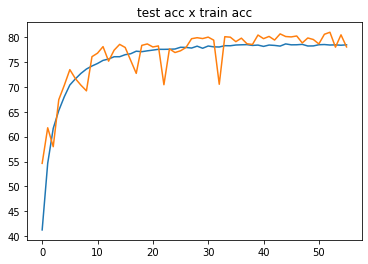

In [7]:
plt.title("test acc x train acc")
plt.plot(model_train_acc)
plt.plot(model_test_acc)
plt.show()

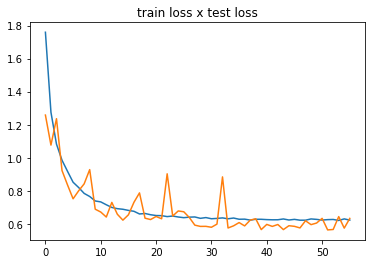

In [8]:
plt.title("train loss x test loss")
plt.plot(model_train_loss)
plt.plot(model_test_loss)
plt.show()

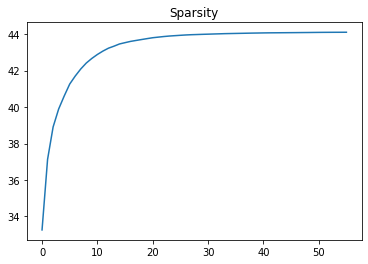

In [9]:
plt.title("Sparsity")
plt.plot(model_sparsity)
plt.show()

In [10]:
model = keras.models.load_model('test_3.h5')

In [11]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    figure(figsize=(10, 7), dpi=80)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm[:,0])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(cm[i, j]*100/1000) + "%",
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')

In [12]:
test_accuracy = tf.keras.metrics.Accuracy()
logits = model(x_test, training=False)
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
test_accuracy(prediction, y_test)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 80.990%


Confusion matrix, without normalization


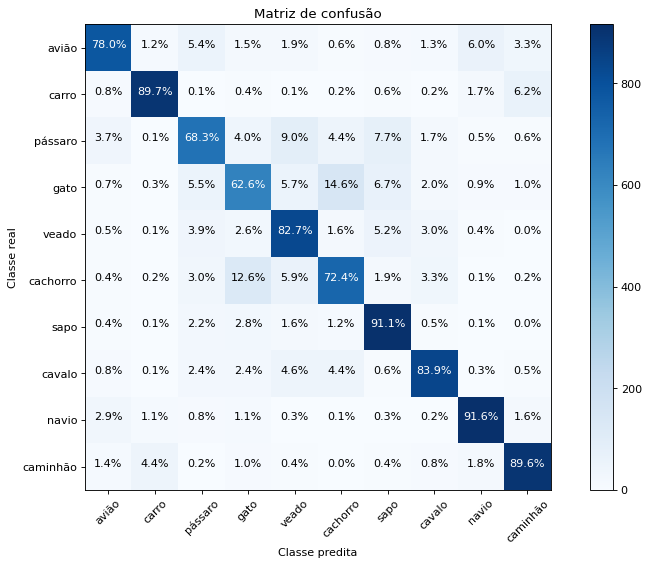

In [13]:
classes = ["avião","carro","pássaro","gato","veado","cachorro","sapo","cavalo","navio","caminhão"]
cm = confusion_matrix(y_true=y_test, y_pred=prediction)
plot_confusion_matrix(cm=cm, classes=classes, title='Matriz de confusão')